In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.MStorch import MultiSlice, LARBED, SED
from src.util import toCPU, toGPU, device, SimulationCell
from wfRead import readPhaseGrating, wfRead


device: using cuda:0
default datatype: using torch.float32


### run zmult to generate phase grating (phase object)  
zmult will generate:
1. temp.pg : phase grating
2. probe.wf : electron wave

In [2]:
! zmult64 110.ms -output 1


 ELECTRON DIFFRACTION BY MULTISLICE METHOD
 J.M. ZUO, UIUC, 2005 and modified 2007 & 2008

 Input file : 110.ms    
  
 Title : _sf _file _cor _new _abs
  
 INPUT FLAGS:
  
 FILE (1 to use file for atomic coords) :            1
 XYZ  (1 to use xyz format) :            0
 NEW  (1 to use input without dw) :            1
 ABS  (1 to include mean absorption) :            1
 COR  (1 to include C5 and other aberr) :            1
 SF   (1 to use default table) :            1
 AUTO (1 to use autoslice) :            0
 PAR  (1 to read a list of TEM parameters) :            1

 THE 2-D CELL OF THE DIRECT SPACE IS DEFINED BY 
        a =    108.60000
        b =    107.50880
    gamma =  90.00000
    caxis =   7.67920

  Number of Atoms :         4480
  

 THERE ARE     4480 ATOMS IN THE CELL, THEY ARE
  1  0.018750  0.008929  0.000000 1.0000
  1  0.668750  0.687500  0.000000 1.0000
  1  0.668750  0.651786  0.000000 1.0000
  1  0.668750  0.723214  0.000000 1.0000
  1  0.668750  0.758929  0.00000

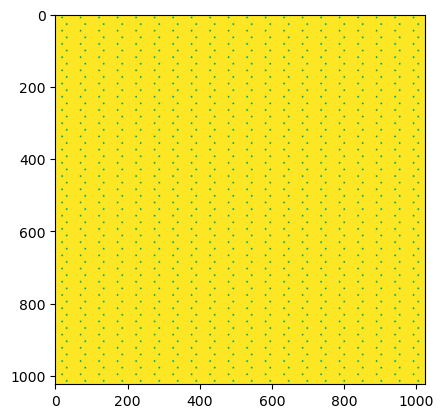

In [3]:
pg = readPhaseGrating(r'temp.pg', (1024, 1024), 4)

plt.imshow(np.abs(pg[0]))

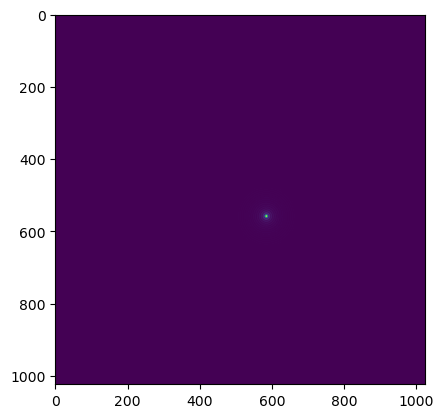

In [4]:
# note that the probe need to be transposed
probe = wfRead('probe.wf')[0][0].T

plt.imshow(np.abs(probe))


### define the simulation cell
Here are some redundancy, but usually you will only need to set it once so it should be fine

In [5]:
simCell = SimulationCell(1024, 1024, 108.6, 107.5088, 90.0000)

### for one simulation, use MultiSlice class

In [6]:
multi = MultiSlice(simulationCell=simCell,
                   zStep=7.6795/4,
                   nSlice=200, 
                   kV=300, 
                   potential=toGPU(pg), 
                   tilt=(0,0)
                  ).to(device)

c:\Users\hcni2\.conda\envs\torch\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
dp = multi.simulate(toGPU(probe))

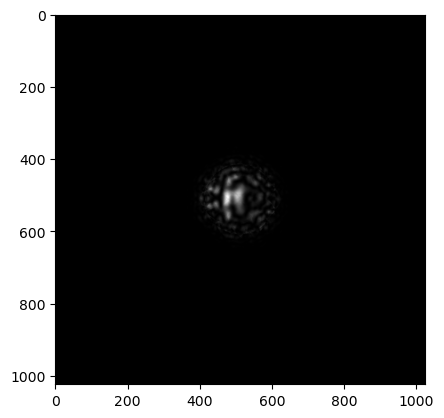

In [8]:
plt.imshow(toCPU(dp), cmap='gray')

### using different electron beam
we can also do SAED with broad beam (all ones matrix)

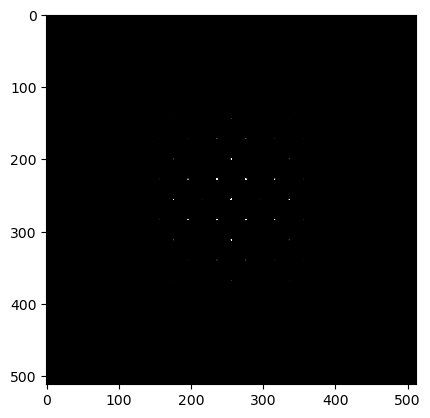

In [10]:
broadBeam = torch.ones(1024, 1024, dtype=torch.complex64, device=device)
SAED = multi.simulate(broadBeam, [50,100,150,199])
plt.imshow(toCPU(SAED)[0,256:768,256:768], cmap='gray', vmax=6e9)

### initialize SEND (4D-STEM) simulation
SED is a wrapper class of MulitSlice for SEND simulation

In [11]:
sed = SED(simulationCell=simCell,
          zStep=7.6792/4,
          nSlice=200, 
          nStep=(24,17), 
          scanSize=(0.050000, 0.0714285/2), 
          kV=300, 
          potential=toGPU(pg), 
          tilt=(0,0)
         ).to(device)

### run the simulation

In [12]:
sim = sed.simulate(toGPU(probe))

### move the result back to cpu  
simCPU will be a normal numpy array

In [13]:
simCPU = toCPU(sim)


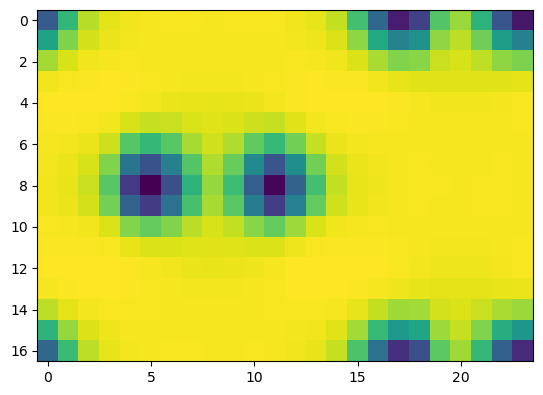

In [14]:
plt.imshow(np.sum(simCPU, axis=(2,3)))

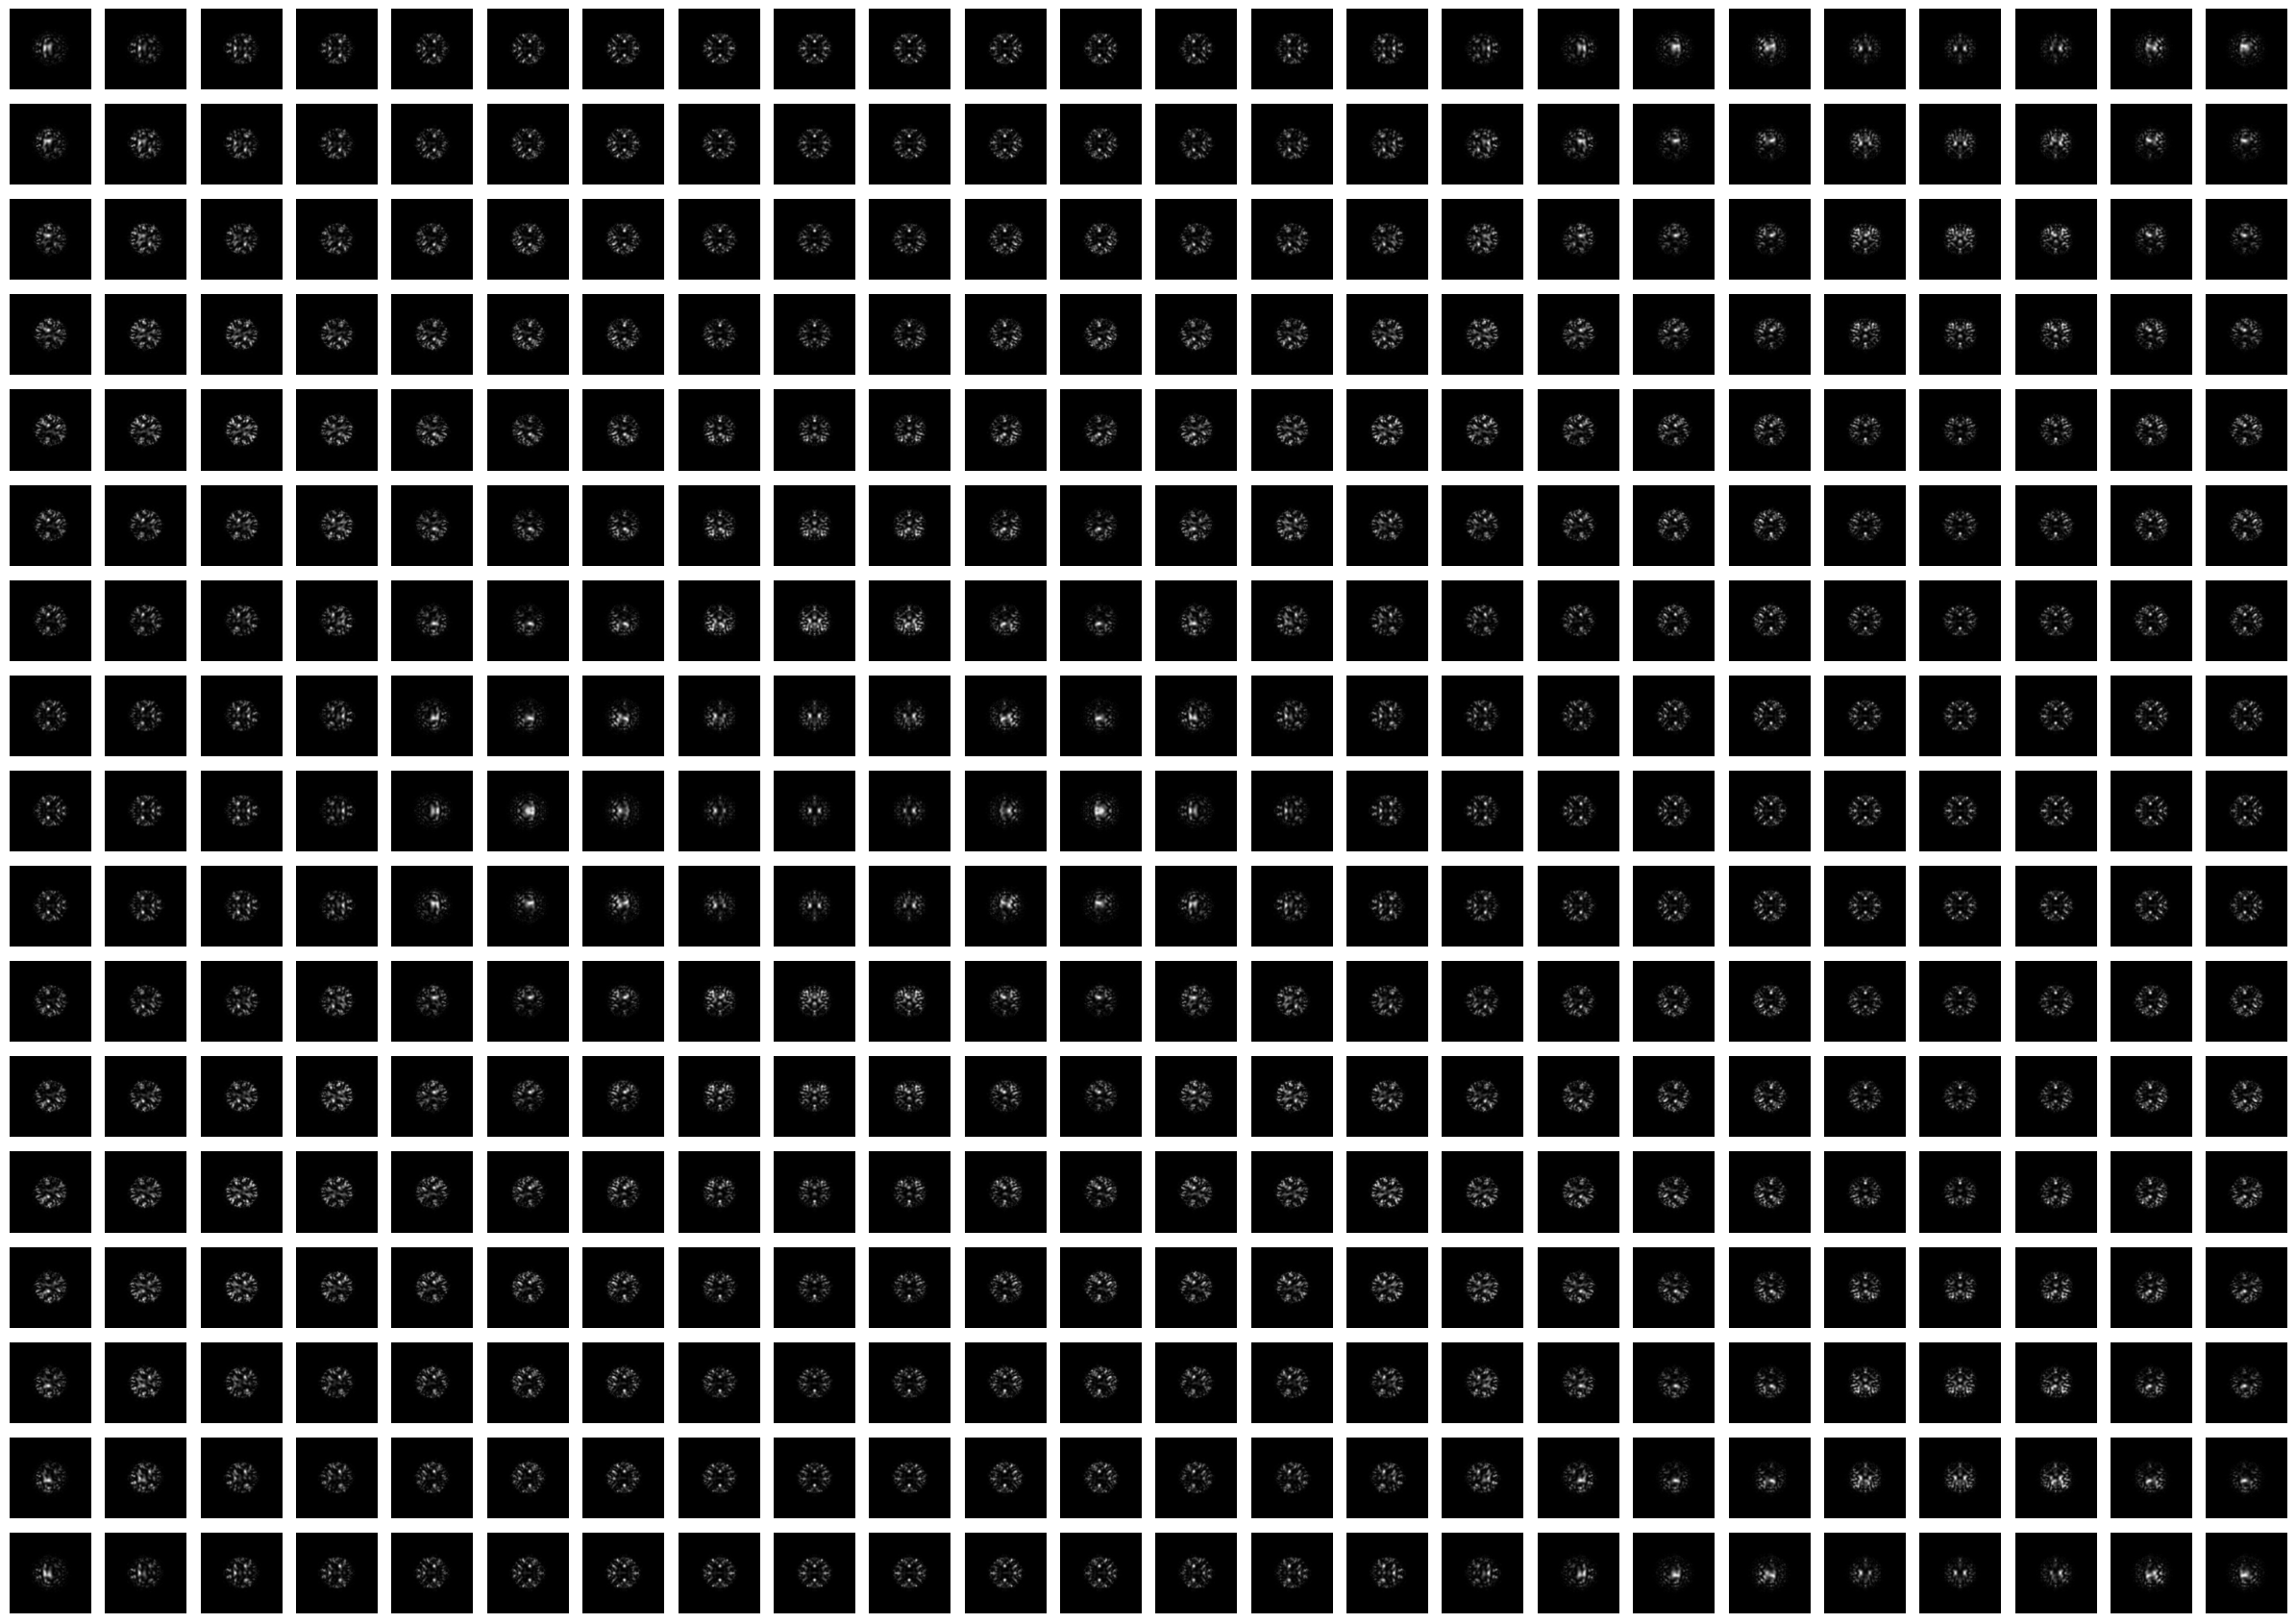

In [15]:
fig, axes = plt.subplots(17, 24, figsize=(24, 17))
for i in range(17):
    for j in range(24):
        ax = axes[i, j]
        ax.imshow(simCPU[i, j, 256:768, 256:768], cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
%matplotlib qt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(simCPU[0, 0], cmap='gray')
ax.axis('off')
def update(frame):
    i = frame // 24
    j = frame % 24
    im.set_array(simCPU[i, j, 256:768, 256:768])
    return [im]

ani = FuncAnimation(fig, update, frames=17*24, blit=True)
plt.show()

### all the phase grating can be access and modified

In [19]:
%matplotlib inline
## display the potential
plt.imshow(toCPU(torch.abs(multi.slices[2].object)))

In [51]:
## change the potential
multi.slices[0].object.data = torch.zeros_like(multi.slices[1].object.data)